In [5]:
%matplotlib inline
import os
import glob
import datetime
import warnings

from multiprocessing import Pool

import tqdm
import netCDF4
import pyart
import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl

warnings.simplefilter("ignore")

In [6]:
with netCDF4.Dataset('../saved_mask/CLUTTER_map_CPOL_20061210.nc') as ncid:
    rclut = ncid['range'][:].filled(0)
    aziclut = ncid['azimuth'][:].filled(0)

In [7]:

# flist = sorted(glob.glob('/g/data2/rr5/CPOL_radar/CPOL_level_1a/2017/20170101/*.nc'))

In [8]:
def read_radar(infile):
    with netCDF4.Dataset(infile) as ncid:
        sti = ncid['sweep_start_ray_index'][0].data
        edi = ncid['sweep_end_ray_index'][0].data
        r = ncid['range'][:].data
        elevation = ncid['elevation'][slice(sti, edi)]
        
        azi = ncid['azimuth'][slice(sti, edi)].data
        refl = ncid['DBZ'][slice(sti, edi)].filled(np.NaN)

    mask = np.zeros((len(azi), len(r)))
    for rsl, asl in zip(rclut, aziclut):
        rpos = np.argmin(np.abs(r - rsl))
        apos = np.argmin(np.abs(azi - asl))
        mask[apos, rpos] = 1

    return refl[mask == 1], np.mean(elevation)

In [31]:
for year in range(2006, 2007):
    flist = sorted(glob.glob(f'/g/data2/rr5/CPOL_radar/CPOL_level_1a/{year}/{year}030*/*.nc'))
    if len(flist) == 0:
        continue

    with Pool(16) as pool:
        rslt = list(tqdm.tqdm_notebook(pool.imap(read_radar, flist), total=len(flist)))

    y = np.zeros((len(rslt)))
    y2 = np.zeros((len(rslt)))
    for cnt, (dbz, ele) in enumerate(rslt):
#         y[cnt] = dbz
        y[cnt] = np.nanpercentile(dbz, 95)
        y2[cnt] = ele

#     pl.plot(y2)
#     pl.title(str(year))
#     pl.show()

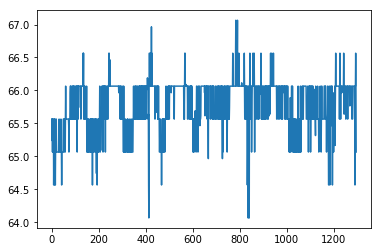

In [32]:
pl.plot(y)

In [33]:
np.mean(y)

65.76780271139754

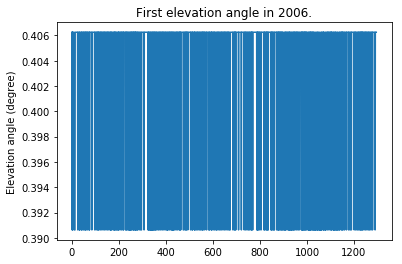

In [39]:
pl.figure()
pl.plot(y2)
pl.title('First elevation angle in 2006.')
pl.ylabel('Elevation angle (degree)')
pl.savefig('Elev. angle 2006.png', dpi=125)

In [35]:
np.unique(y2)

array([0.390625, 0.40625 ])

In [13]:
y[y2 == 0.4375].mean()

67.40375995725257

In [14]:
y[y2 == 0.40625].mean()

67.42046852523326

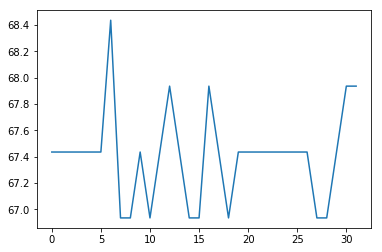

In [15]:
pl.plot(y[y2 == 0.4375])

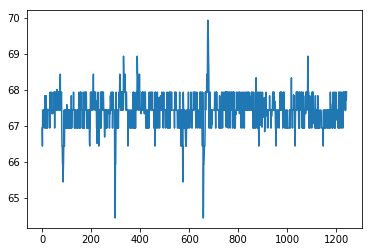

In [30]:
pl.plot(y[y2 == 0.40625])